# Лаба 6

# Метод конечных элементов для уравнения Пуассона

## Необходимые импорты

In [1]:
import scipy as sp
from scipy import io
import meshpy.triangle as triangle
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plot
from scipy.interpolate import griddata

## Шаг 1. Постороить сеть

In [2]:
def draw_plot(l_solution, title=""):
    x, y = np.meshgrid(xi, yi)
    g = griddata((points[:, 0], points[:, 1]), l_solution, (x, y))
    plot.figure()
    plot.figure(figsize=(7, 7))
    plot.title(title)
    plot.contourf(x, y, g, cmap="hsv")
    plot.colorbar()
    plot.axis("equal")
    plot.show()

In [3]:
def round_trip_connect(start, end):
    return [(i, i + 1) for i in range(start, end)] + [(end, start)]


def get_grid():
    points = [(np.cos(angle), np.sin(angle)) for angle in np.linspace(0, 2*np.pi, 120, endpoint=False)]
  
    info = triangle.MeshInfo()
    info.set_points(points)
    info.set_facets(round_trip_connect(0, len(points)-1))

    mesh = triangle.build(info, max_volume=1e-3, min_angle=30)

    points = np.array(mesh.points)
    triangles = np.array(mesh.elements)
    facets = np.array(mesh.facets)
    
    return (points, triangles, facets)

<Figure size 432x288 with 0 Axes>

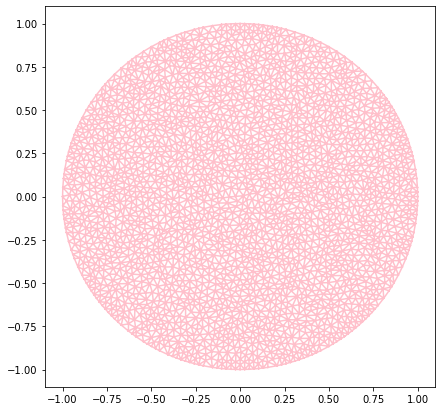

In [4]:
points, triangles, facets = get_grid()
plot.figure()
plot.figure(figsize=(7, 7))
plot.triplot(points[:, 0], points[:, 1], triangles, color="pink")
plot.show()

## Шаг 2. Составить матрицу жёсткости

In [5]:
def get_points_for(triangle):
    return [(points[i][0], points[i][1]) for i in triangle]

def get_g_matrix(triangle):
    l_points = get_points_for(triangle)
    x1, y1 = l_points[0]
    x2, y2 = l_points[1]
    x3, y3 = l_points[2]
    g_matrix = [[1, 1, 1], [x1, x2, x3], [y1, y2, y3]]
    h_matrix = [[0, 0], [1, 0], [0, 1]]
    return np.linalg.inv(g_matrix) @ h_matrix 


def get_area(triangle):
    l_points = get_points_for(triangle)
    x1, y1 = l_points[0]
    x2, y2 = l_points[1]
    x3, y3 = l_points[2]
    return 0.5 * np.linalg.det([
        [x2 - x1, y2 - y1],
        [x3 - x1, y3 - y1]
    ])

def get_m(triangle):
    G = get_g_matrix(triangle)
    T = get_area(triangle)
    return T * (G @ G.transpose())

## Шаг 3. Создаем правую часть уравнения

In [6]:
def get_vector():
    vector = np.zeros(len(points))
    for t in triangles:
        p1, p2, p3 = t
        area = get_area(t)
        vector[p1] += 1/3 * area
        vector[p2] += 1/3 * area
        vector[p3] += 1/3 * area
    for f_point in (p[0] for p in facets):
        vector[f_point] = 0
    return vector

## Шаг 4.  Проверяем свой код

In [7]:
def get_a_matrix():
    s_matrixes_with_points = [(get_m(t), t) for t in triangles]
    A = np.zeros((len(points), len(points)))
    for mp in s_matrixes_with_points:
        m, l_points = mp
        for i, p1 in enumerate(l_points):
            for j, p2 in enumerate(l_points):
                A[p1, p2] += m[i, j]
    for f_point in (p[0] for p in facets):
        A[f_point, ...] = A[..., f_point] = 0  
        A[f_point, f_point] = 1
    return A

In [8]:
A = get_a_matrix()
vector = get_vector()
solution = np.linalg.solve(A, vector)
xi = np.linspace(-1, 1, 200) 
yi = np.linspace(-1, 1, 200) 

<Figure size 432x288 with 0 Axes>

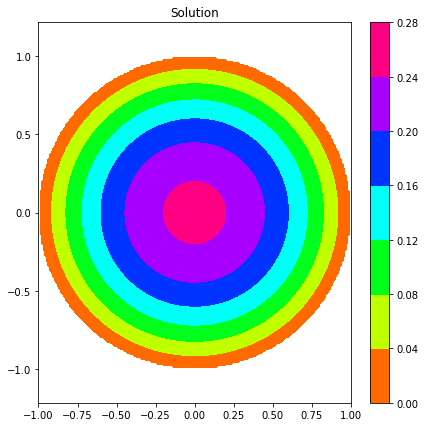

In [9]:
draw_plot(solution, title="Solution")

<Figure size 432x288 with 0 Axes>

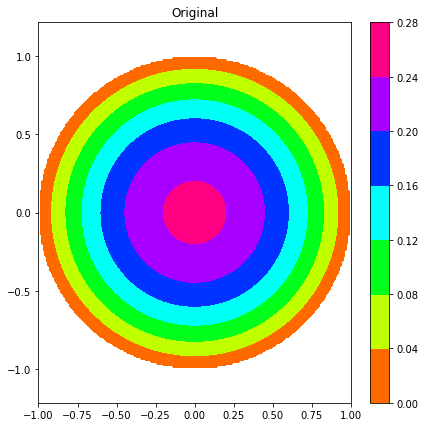

In [10]:
true_solution = (1 - points[:, 0]**2 - points[:, 1]**2)/4
draw_plot(true_solution, title="Original")

<Figure size 432x288 with 0 Axes>

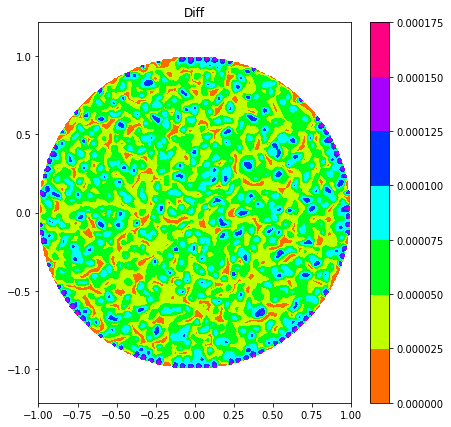

In [11]:
diff = np.array([abs(solution[i] - true_solution[i]) for i in range(len(points))])
draw_plot(diff, title="Diff")

## Шаг 5. Решаем задачу для заданного региона.

In [12]:
def needs_refinement(vertices, area):
    bary = np.sum(np.array(vertices), axis=0) / 3
    max_area = 0.001 + (la.norm(bary, np.inf) - 1) * 0.01
    return bool(area > max_area)


def get_grid_with_hole(r, x, y, eps=0):
    points = [(np.cos(angle), np.sin(angle)) for angle in np.linspace(0, 2*np.pi, 120, endpoint=False)]
    points += [(r * np.cos(angle) + x - eps, r * np.sin(angle) + y) for angle in np.linspace(0, 2*np.pi, 120, endpoint=False)]


    info = triangle.MeshInfo()
    info.set_points(points)
    info.set_facets(round_trip_connect(0, len(points)-1))
    info.set_holes([(x, y)])

    mesh = triangle.build(info, max_volume=1e-3, min_angle=30)

    points = np.array(mesh.points)
    triangles = np.array(mesh.elements)
    facets = np.array(mesh.facets)
    
    return (points, triangles, facets)

<Figure size 432x288 with 0 Axes>

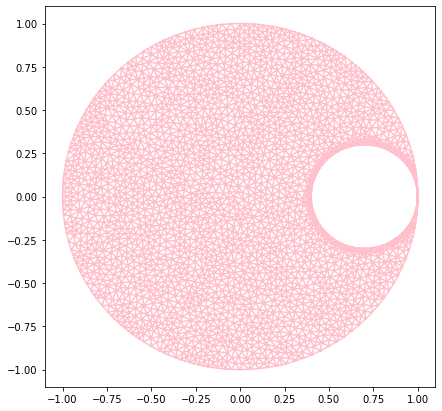

In [13]:
points, triangles, facets = get_grid_with_hole(r=0.3, x=0.7, y=0, eps=0.0001)
plot.figure()
plot.figure(figsize=(7, 7))
plot.triplot(points[:, 0], points[:, 1], triangles, color="pink")
plot.show()

In [14]:
from functools import reduce

summer = lambda x, y: x + y

def get_integrate():
    return reduce(summer, [1/3 * get_area(t) * sum([solution[p] for p in t]) for t in triangles])

<Figure size 432x288 with 0 Axes>

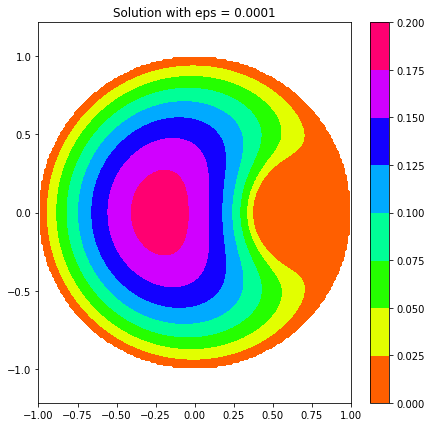

eps: 0.0001, integral: 0.2488971794626866


In [15]:
vector = get_vector()
A = get_a_matrix()
solution = np.linalg.solve(A, vector)
draw_plot(solution, title=f"Solution with eps = {0.0001}")
intg1 = get_integrate()
print(f"eps: {0.0001}, integral: {intg1}")

In [16]:
points, triangles, facets = get_grid_with_hole(r=0.3, x=0.7, y=0, eps=2*0.0001)

<Figure size 432x288 with 0 Axes>

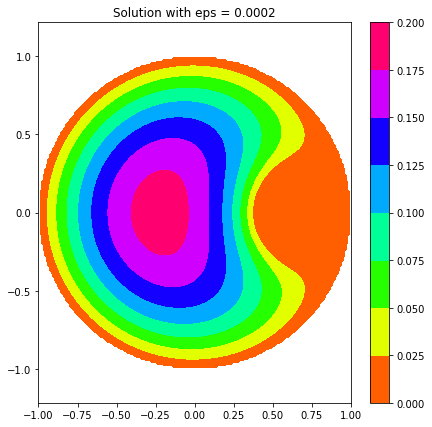

eps: 0.0002, integral: 0.24886605860754732


In [17]:
vector = get_vector()
A = get_a_matrix()
solution = np.linalg.solve(A, vector)
draw_plot(solution, title=f"Solution with eps = {2 * 0.0001}")
intg2 = get_integrate()
print(f"eps: {2 * 0.0001}, integral: {intg2}")

In [18]:
print(f"integral diff: {abs(intg2 - intg1)}")

integral diff: 3.1120855139288306e-05


## Шаг 6. Посчитать поток жидкости

In [19]:
points, triangles, facets = get_grid_with_hole(r=0.3, x=0.699, y=0)

In [20]:
vector = get_vector()
A = get_a_matrix()
solution = np.linalg.solve(A, vector)
intg = get_integrate()
print(f"integral with x = {0.7} and r = {0.3}: {intg}")

integral with x = 0.7 and r = 0.3: 0.24865751113934115


In [21]:
points, triangles, facets = get_grid_with_hole(r=0.3, x=0.5, y=0)

In [22]:
vector = get_vector()
A = get_a_matrix()
solution = np.linalg.solve(A, vector)
intg = get_integrate()
print(f"integral with x = {0.5} and r = {0.3}: {intg}")

integral with x = 0.5 and r = 0.3: 0.19114095740274833
